In [2]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from nltools.file_reader import onsets_to_dm
from nltools.stats import regress, zscore
from nltools.data import Brain_Data, Design_Matrix
from nltools.stats import find_spikes 
from nilearn.plotting import view_img, glass_brain, plot_stat_map
from bids import BIDSLayout, BIDSValidator

In [3]:
data_dir = '/Users/michael/Dropbox/work/data/dartbrains/data/localizer'
layout = BIDSLayout(data_dir,derivatives=True)

/usr/local/Caskroom/miniconda/base/envs/pymri/lib/python3.10/site-packages/bids/layout/validation.py:156: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Load in the preprocessed data from one participant:

In [30]:
sbj = 'S01'
bold_file = layout.get(subject=sbj,task='localizer',scope='derivatives',
                       suffix='bold',extension='nii.gz',return_type='file')
bold = Brain_Data(bold_file)
TR = layout.get_tr() # TR duration
n_TR = len(bold) # number of volumes (i.e., TRs) 


In [16]:
confound_file = layout.get(subject='S01', scope='derivatives', extension='.tsv',return_type='file')[0]
print(confound_file)
confounds = pd.read_csv(confound_file,sep='\t')
confounds.head()


/Users/michael/Dropbox/work/data/dartbrains/data/localizer/derivatives/fmriprep/sub-S01/func/sub-S01_task-localizer_desc-confounds_regressors.tsv


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,rot_x_derivative1_power2,rot_x_power2,rot_y,rot_y_derivative1,rot_y_derivative1_power2,rot_y_power2,rot_z,rot_z_derivative1,rot_z_derivative1_power2,rot_z_power2
0,5164.630182,NaN,NaN,2.667340e+07,4006.007667,NaN,1.604810e+07,NaN,3753.537871,NaN,...,NaN,4.016403e-07,0.000344,NaN,NaN,1.180596e-07,-0.000701,NaN,NaN,4.914346e-07
1,5178.481411,13.851229,191.856548,2.681667e+07,4011.819383,5.811716,1.609469e+07,33.776043,3760.408417,6.870546,...,8.622980e-09,2.925631e-07,0.000569,0.000225,5.063355e-08,3.233253e-07,-0.000776,-0.000075,5.666476e-09,6.026417e-07
2,5161.040643,-17.440768,304.180395,2.663634e+07,4006.766409,-5.052974,1.605418e+07,25.532548,3756.426086,-3.982332,...,6.975673e-08,6.480347e-07,0.000655,0.000086,7.409422e-09,4.286255e-07,-0.000524,0.000253,6.390582e-08,2.740564e-07
3,5150.604178,-10.436465,108.919794,2.652872e+07,4008.586021,1.819612,1.606876e+07,3.310987,3751.566090,-4.859996,...,1.673784e-07,1.567265e-07,0.000554,-0.000101,1.011674e-08,3.070412e-07,-0.000605,-0.000082,6.722360e-09,3.666230e-07
4,5172.441161,21.836983,476.853810,2.675415e+07,4007.189291,-1.396730,1.605757e+07,1.950854,3746.298200,-5.267890,...,2.102616e-08,2.925631e-07,0.000997,0.000443,1.959195e-07,9.934926e-07,-0.000840,-0.000235,5.510428e-08,7.059982e-07


<AxesSubplot: >

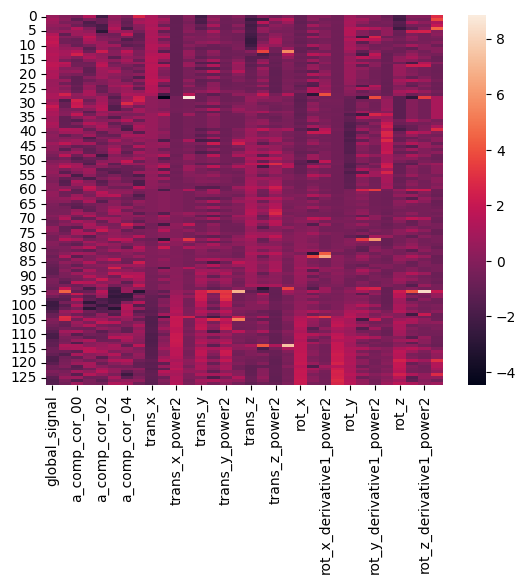

In [39]:
inc = ['global_signal','framewise_displacement','a_comp_cor_00','a_comp_cor_01',\
       'a_comp_cor_02','a_comp_cor_03','a_comp_cor_04','a_comp_cor_05', \
       'trans_x','trans_x_derivative1','trans_x_power2','trans_x_derivative1_power2', \
       'trans_y','trans_y_derivative1','trans_y_power2','trans_y_derivative1_power2', \
       'trans_z','trans_z_derivative1','trans_z_power2','trans_z_derivative1_power2', \
       'rot_x','rot_x_derivative1','rot_x_derivative1_power2','rot_x_power2', \
       'rot_y','rot_y_derivative1','rot_y_derivative1_power2','rot_y_power2', \
       'rot_z','rot_z_derivative1','rot_z_derivative1_power2','rot_z_power2']
mc = confounds[inc]
z_mc = zscore(mc)
z_mc.fillna(value=0,inplace=True)
spikes = confounds.loc[:,confounds.columns.str.startswith('motion_outlier')]
nuisance = Design_Matrix(pd.concat([z_mc,spikes],axis=1),sampling_freq=1/TR)

sns.heatmap(nuisance)
